# Exploring the Data and Models

The paper:
`Machine learning-based automatedphenotyping of inflammatory nocifensivebehavior in mice`

In this notebook we attempt to explore the data and its structure.

Afterwards we will train our own classfiiers and compare their perofrmance to the one used in the paper.

## Setup

In [2]:
import scipy.io
import pandas as pd
import numpy as np
import os
import h5py
import re
from datetime import datetime
from collections import defaultdict


# set the paths for data
data_folder = os.path.join(os.getcwd(), 'Data')
deeplabcut_folder = os.path.join(data_folder, 'DeepLabCut')
gentleboost_folder = os.path.join(data_folder, 'GentleBoost')

## Exploring the Gentle Boost Classifier Data

### Looking at the trainedModelclassifier.mat

The `trainedModelclassifier.mat` represents the Matlab structure of the GentleBoost classifier.


In [5]:
mat = scipy.io.loadmat(os.path.join(gentleboost_folder, 'trainedModelclassifier.mat'))

print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'trainedModelclassifier', '__function_workspace__'])


In [6]:
model = mat['trainedModelclassifier']
display(model)

array([[(MatlabFunction([[(array(['C:\\Program Files\\MATLAB\\R2019a'], dtype='<U30'), array(['\\'], dtype='<U1'), array(['@'], dtype='<U1'), array([[(array(['sf%0@(x)exportableModel.predictFcn(predictorExtractionFcn(x))'],
                                       dtype='<U61'), array(['anonymous'], dtype='<U9'), array(['C:\\Program Files\\MATLAB\\R2019a\\toolbox\\stats\\mlearnapp\\+mlearnapp\\+internal\\+model\\DatasetSpecification.m'],
                                       dtype='<U105'), MatlabOpaque([(b'', b'MCOS', b'function_handle_workspace', array([[3707764736],
                                                      [         2],
                                                      [         1],
                                                      [         1],
                                                      [         1],
                                                      [         1]], dtype=uint32))                             ],
                                      

In [7]:
# Print the structure to understand what's inside
print("Model structure:")
print(type(model))
print(model.dtype)  # This will show the fields available in the structure

# You can access different components like this:
# If it's a MATLAB struct, it will have named fields
for field_name in model.dtype.names:
    print(f"\nField: {field_name}")
    print(model[field_name][0, 0])  # MATLAB structs are usually accessed this way

Model structure:
<class 'numpy.ndarray'>
[('predictFcn', 'O'), ('ClassificationEnsemble', 'O'), ('About', 'O'), ('HowToPredict', 'O')]

Field: predictFcn
[[(array(['C:\\Program Files\\MATLAB\\R2019a'], dtype='<U30'), array(['\\'], dtype='<U1'), array(['@'], dtype='<U1'), array([[(array(['sf%0@(x)exportableModel.predictFcn(predictorExtractionFcn(x))'],
                dtype='<U61'), array(['anonymous'], dtype='<U9'), array(['C:\\Program Files\\MATLAB\\R2019a\\toolbox\\stats\\mlearnapp\\+mlearnapp\\+internal\\+model\\DatasetSpecification.m'],
                dtype='<U105'), MatlabOpaque([(b'', b'MCOS', b'function_handle_workspace', array([[3707764736],
                               [         2],
                               [         1],
                               [         1],
                               [         1],
                               [         1]], dtype=uint32))                             ],
                       dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), 

Details to note:

- This is a MATLAB Classification Ensemble model (gentleBoost) exported form MATLAB's Classification Learner app

1. IT expects 1047 features as input (predictors)
2. It's stored as a MATLAB object with specific internal structures

In [8]:
# Try to access the ClassificationEnsemble object
ensemble = model['ClassificationEnsemble'][0,0]

# Let's try to see what's inside the ensemble
print("Ensemble attributes:")
for attr in dir(ensemble):
    if not attr.startswith('_'):  # Skip private attributes
        try:
            value = getattr(ensemble, attr)
            print(f"{attr}: {value}")
        except:
            print(f"Could not access {attr}")

Ensemble attributes:
T: [(b'', b'MCOS', b'classreg.learning.classif.ClassificationEnsemble', array([[3707764736],
        [         2],
        [         1],
        [         1],
        [       342],
        [        14]], dtype=uint32))                                                    ]
all: <built-in method all of MatlabOpaque object at 0x112c26040>
any: <built-in method any of MatlabOpaque object at 0x112c26040>
argmax: <built-in method argmax of MatlabOpaque object at 0x112c26040>
argmin: <built-in method argmin of MatlabOpaque object at 0x112c26040>
argpartition: <built-in method argpartition of MatlabOpaque object at 0x112c26040>
argsort: <built-in method argsort of MatlabOpaque object at 0x112c26040>
astype: <built-in method astype of MatlabOpaque object at 0x112c26040>
base: [(b'', b'MCOS', b'classreg.learning.classif.ClassificationEnsemble', array([[3707764736],
        [         2],
        [         1],
        [         1],
        [       342],
        [        14]], d

### Examining training data

In [3]:
train40_folder = os.path.join(gentleboost_folder, 'train40')
training_labels_folder = os.path.join(gentleboost_folder, 'training_labels')

# print lenghts of the folders
print(len(os.listdir(train40_folder)))
print(len(os.listdir(training_labels_folder)))


0
40


### Data Manipulation - concatenating all the training data into one numpy array

In [10]:
# Create a new directory for renamed files
renamed_folder = os.path.join(gentleboost_folder, 'train_renamed')
os.makedirs(renamed_folder, exist_ok=True)

# Function to extract info from training filenames
def extract_training_info(filename):
    # Pattern to extract Arena, Run, Tetrad, and Date
    pattern = r"Arena(\d)-Run(\d) Tetrad (\d) (\d+_\d+_\d+ \d+_\d+_\d+ [AP]M)"
    match = re.search(pattern, filename)
    if match:
        arena = match.group(1)
        run = match.group(2)
        tetrad = match.group(3)
        date_str = match.group(4)
        date = datetime.strptime(date_str, "%m_%d_%Y %I_%M_%S %p")
        return {
            'arena': arena,
            'run': run,
            'tetrad': tetrad,
            'date': date,
            'original_filename': filename
        }
    else:
        return None

# Step 1: Extract info from training files
train_files_info = []
for filename in os.listdir(train40_folder):
    info = extract_training_info(filename)
    if info:
        train_files_info.append(info)
    else:
        print(f"Filename does not match pattern: {filename}")

# Step 2: Group training files by (Arena, Run, Tetrad)
training_groups = defaultdict(list)
for info in train_files_info:
    key = (info['arena'], info['run'], info['tetrad'])
    training_groups[key].append(info)

# Step 3: Sort each group by date and assign suffixes
suffixes = ['', 'a', 'b', 'c', 'd', 'e']  # Extend if needed
renamed_files = []

for key, files in training_groups.items():
    # Sort files by date
    sorted_files = sorted(files, key=lambda x: x['date'])
    # Check if we have enough suffixes
    if len(sorted_files) > len(suffixes):
        raise ValueError(f"Not enough suffixes for group {key}")
    # Assign suffixes and rename files
    for idx, file_info in enumerate(sorted_files):
        suffix = suffixes[idx]
        new_filename = f"inpA{file_info['arena']}R{file_info['run']}T{file_info['tetrad']}{suffix}labels.h5"
        # Append to list for later matching
        renamed_files.append({
            'original_filename': file_info['original_filename'],
            'new_filename': new_filename,
            'date': file_info['date'],
            'arena': file_info['arena'],
            'run': file_info['run'],
            'tetrad': file_info['tetrad'],
            'suffix': suffix
        })
        # Rename the file to the new directory
        original_path = os.path.join(train40_folder, file_info['original_filename'])
        new_path = os.path.join(renamed_folder, new_filename)
        os.rename(original_path, new_path)
        print(f"Renamed '{file_info['original_filename']}' to '{new_filename}' in '{renamed_folder}'")

Renamed 'Arena1-Run1 Tetrad 2 8_20_2018 9_10_26 AM 2DeepCut_resnet50_footshuffle_missFeb24shuffle1_750000.h5' to 'inpA1R1T2labels.h5' in '/Users/julienh/Desktop/Beliz/mouse-lick-classification/Data/GentleBoost/train_renamed'
Renamed 'Arena1-Run1 Tetrad 2 8_21_2018 8_58_43 AM 2DeepCut_resnet50_footshuffle_missFeb24shuffle1_750000.h5' to 'inpA1R1T2alabels.h5' in '/Users/julienh/Desktop/Beliz/mouse-lick-classification/Data/GentleBoost/train_renamed'
Renamed 'Arena1-Run1 Tetrad 2 8_27_2018 8_54_22 AM 2DeepCut_resnet50_footshuffle_missFeb24shuffle1_750000.h5' to 'inpA1R1T2blabels.h5' in '/Users/julienh/Desktop/Beliz/mouse-lick-classification/Data/GentleBoost/train_renamed'
Renamed 'Arena4-Run2 Tetrad 3 8_20_2018 12_25_28 PM 3DeepCut_resnet50_footshuffle_missFeb24shuffle1_750000.h5' to 'inpA4R2T3labels.h5' in '/Users/julienh/Desktop/Beliz/mouse-lick-classification/Data/GentleBoost/train_renamed'
Renamed 'Arena4-Run2 Tetrad 3 8_27_2018 11_57_54 AM 3DeepCut_resnet50_footshuffle_missFeb24shuffl

In [ ]:
trained_renamed_folder = os.path.join(gentleboost_folder, 'train_renamed')

In [9]:

label_files = os.listdir(training_labels_folder)
data_files = os.listdir(trained_renamed_folder)

# Create a mapping from label filenames to their info
def extract_label_info(filename):
    # Updated pattern to allow an optional space before "labels"
    pattern = r"inpA(\d)R(\d)T(\d)([a-z]?)\s*labels\.h5"
    match = re.match(pattern, filename)
    if match:
        return {
            'arena': match.group(1),
            'run': match.group(2),
            'tetrad': match.group(3),
            'suffix': match.group(4),
            'filename': filename
        }
    else:
        return None

label_files_info = []
data_files_info = []

for filename in label_files:
    info = extract_label_info(filename)
    if info:
        label_files_info.append(info)
    else:
        print(f"Label filename does not match pattern: {filename}")

for filename in data_files:
    info = extract_label_info(filename)
    if info:
        data_files_info.append(info)
    else:
        print(f"Data filename does not match pattern: {filename}")

# Now match based on arena, run, tetrad, and suffix
matched_pairs = []

for label_info in label_files_info:
    for train_info in data_files_info:
        if (label_info['arena'] == train_info['arena'] and
            label_info['run'] == train_info['run'] and
            label_info['tetrad'] == train_info['tetrad'] and
            label_info['suffix'] == train_info['suffix']):
            matched_pairs.append((train_info['filename'], label_info['filename']))
            break
    else:
        print(f"No matching training file for label file: {label_info['filename']}")

# Step 5: Use the matched pairs as needed
print("\nMatched Pairs:")
for train_file, label_file in matched_pairs:
    print(f"Training File: {train_file} <--> Label File: {label_file}")



Matched Pairs:
Training File: inpA3R1T1blabels.h5 <--> Label File: inpA3R1T1blabels.h5
Training File: inpA2R2T1labels.h5 <--> Label File: inpA2R2T1 labels.h5
Training File: inpA3R2T4labels.h5 <--> Label File: inpA3R2T4 labels.h5
Training File: inpA4R2T4alabels.h5 <--> Label File: inpA4R2T4alabels.h5
Training File: inpA1R1T2blabels.h5 <--> Label File: inpA1R1T2blabels.h5
Training File: inpA4R2T2labels.h5 <--> Label File: inpA4R2T2 labels.h5
Training File: inpA3R1T3labels.h5 <--> Label File: inpA3R1T3 labels.h5
Training File: inpA2R2T1alabels.h5 <--> Label File: inpA2R2T1alabels.h5
Training File: inpA1R2T1labels.h5 <--> Label File: inpA1R2T1 labels.h5
Training File: inpA4R2T4labels.h5 <--> Label File: inpA4R2T4 labels.h5
Training File: inpA4R2T2alabels.h5 <--> Label File: inpA4R2T2alabels.h5
Training File: inpA1R1T1labels.h5 <--> Label File: inpA1R1T1 labels.h5
Training File: inpA4R2T3labels.h5 <--> Label File: inpA4R2T3 labels.h5
Training File: inpA3R1T2labels.h5 <--> Label File: inpA3

In [10]:
matched_pairs

[('inpA3R1T1blabels.h5', 'inpA3R1T1blabels.h5'),
 ('inpA2R2T1labels.h5', 'inpA2R2T1 labels.h5'),
 ('inpA3R2T4labels.h5', 'inpA3R2T4 labels.h5'),
 ('inpA4R2T4alabels.h5', 'inpA4R2T4alabels.h5'),
 ('inpA1R1T2blabels.h5', 'inpA1R1T2blabels.h5'),
 ('inpA4R2T2labels.h5', 'inpA4R2T2 labels.h5'),
 ('inpA3R1T3labels.h5', 'inpA3R1T3 labels.h5'),
 ('inpA2R2T1alabels.h5', 'inpA2R2T1alabels.h5'),
 ('inpA1R2T1labels.h5', 'inpA1R2T1 labels.h5'),
 ('inpA4R2T4labels.h5', 'inpA4R2T4 labels.h5'),
 ('inpA4R2T2alabels.h5', 'inpA4R2T2alabels.h5'),
 ('inpA1R1T1labels.h5', 'inpA1R1T1 labels.h5'),
 ('inpA4R2T3labels.h5', 'inpA4R2T3 labels.h5'),
 ('inpA3R1T2labels.h5', 'inpA3R1T2 labels.h5'),
 ('inpA2R1T1alabels.h5', 'inpA2R1T1alabels.h5'),
 ('inpA3R2T3labels.h5', 'inpA3R2T3 labels.h5'),
 ('inpA1R1T1alabels.h5', 'inpA1R1T1alabels.h5'),
 ('inpA3R1T4labels.h5', 'inpA3R1T4 labels.h5'),
 ('inpA2R1T1labels.h5', 'inpA2R1T1 labels.h5'),
 ('inpA4R2T3alabels.h5', 'inpA4R2T3alabels.h5'),
 ('inpA1R1T2labels.h5', 'inpA1R1

In [11]:
def compare_dimensions(train_data_element, verbose=False):
    # Extract file paths from the train_data element
    sample_train_file = os.path.join(trained_renamed_folder, train_data_element[0])
    sample_label_file = os.path.join(training_labels_folder, train_data_element[1])

    # Open the .h5 file for the dataset
    with h5py.File(sample_train_file, 'r') as f:
        # Access the group
        group = f['df_with_missing']
        
        # Access the dataset
        dataset = group['table']
        data_array = np.array([element[1] for element in dataset[:]])
        if verbose:
            print(f"Dataset shape: {data_array.shape}")

    # Open the .h5 file for the label
    with h5py.File(sample_label_file, 'r') as f:
        labels = f['labels']
        labels_array = labels[:].T
        if verbose:
            print(f"Labels shape: {labels_array.shape}")

    # Compare dimensions
    if data_array.shape[0] == labels_array.shape[0]:
        print("The number of samples in data and labels match.")
    else:
        print("Mismatch in the number of samples between data and labels.")

# Example usage
compare_dimensions(matched_pairs[36], verbose=True)

Dataset shape: (4775, 159)
Labels shape: (4776, 1)
Mismatch in the number of samples between data and labels.


In [12]:
def compute_combined_array(train_data_element, verbose=False):
    # Extract file paths from the train_data element
    sample_train_file = os.path.join(trained_renamed_folder, train_data_element[0])
    sample_label_file = os.path.join(training_labels_folder, train_data_element[1])

    # Open the .h5 file for the dataset
    with h5py.File(sample_train_file, 'r') as f:
        # Access the group
        group = f['df_with_missing']
        
        # Access the dataset
        dataset = group['table']
        data_array = np.array([element[1] for element in dataset[:]])
        if verbose:
            print(f"Dataset (shape: {data_array.shape}):")

    # Open the .h5 file for the label
    with h5py.File(sample_label_file, 'r') as f:
        labels = f['labels']
        labels_array = labels[:].T
        if verbose:
            print(f"Labels (shape: {labels_array.shape}):")

    # Combine into one array
    combined_array = np.concatenate((data_array, labels_array), axis=1)
    if verbose:
        print(f"Combined array (shape: {combined_array.shape}):")

    return combined_array

# Example usage
combined_array = compute_combined_array(matched_pairs[14], verbose=True)

Dataset (shape: (4571, 159)):
Labels (shape: (4571, 1)):
Combined array (shape: (4571, 160)):


In [13]:
# Initialize an empty list to store combined arrays
combined_arrays = []

# Iterate through each element in train_data
# remove index 36 because it has a mismatch in the number of columns
pairs = matched_pairs[:36] + matched_pairs[37:]
for element in pairs:
    combined_array = compute_combined_array(element)
    
    # Check if the number of columns matches the first array
    if combined_arrays and combined_array.shape[1] != combined_arrays[0].shape[1]:
        print(f"Warning: Column mismatch for {element[0]}. Expected {combined_arrays[0].shape[1]}, got {combined_array.shape[1]}.")
        continue  # Skip this array or handle it as needed
    
    combined_arrays.append(combined_array)

# Concatenate all combined arrays into a single numpy array
all_combined_data = np.vstack(combined_arrays)

# Convert the numpy array to a pandas DataFrame
train_data_df = pd.DataFrame(all_combined_data)

# Display the shape of the resulting DataFrame
print(f"Train data DataFrame shape: {train_data_df.shape}")

Train data DataFrame shape: (269659, 160)


In [18]:
# lets save it as a csv file
train_data_df.to_csv(os.path.join(gentleboost_folder, 'train_data.csv'), index=False)

## Training some Classifiers

#### Imports

For training and testing classifiers

In [14]:
import time
from functools import wraps

# sklearn imports
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline


Our helper functions:

- `log_execution_time` to report the time of training and testing. 
- `save_results` to save the results of the training and testing for visualizaton purposes
- `train_and_evaluate_model` to train and evaluate the model.

In [15]:
results_df = pd.DataFrame(columns=['Model', 'Cross-Validation Accuracy', 'Training Accuracy', 'Test Accuracy', 'Precision', 'Recall'])

In [16]:
# Initialize a global DataFrame to store results

def log_execution_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time for {func.__name__}: {execution_time:.4f} seconds")
        # add the execution time to the result
        result['execution_time'] = execution_time
        return result
    return wrapper

def save_results(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Call the original function and capture its output
        result = func(*args, **kwargs)
        
        # Extract the estimator from the arguments
        estimator = args[4]  # Assuming the estimator is the 5th argument

        if isinstance(estimator, Pipeline):
            model_name = estimator.steps[-1][1].__class__.__name__
        else:
            model_name = estimator.__class__.__name__

        cv_accuracy = result['cv_accuracy']
        train_accuracy = result['train_accuracy']
        test_accuracy = result['test_accuracy']
        precision = result['precision']
        recall = result['recall']
        execution_time = result['execution_time']

        # Append the results to the global DataFrame
        current_result_df = pd.DataFrame({
            'Model': [model_name],
            'Cross-Validation Accuracy': [cv_accuracy],
            'Training Accuracy': [train_accuracy],
            'Test Accuracy': [test_accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'Execution Time': [execution_time]
        })
        
        global results_df
        results_df = pd.concat([results_df, current_result_df], ignore_index=True)
        
        return result
    return wrapper

# Apply the new decorator to the train_and_evaluate_model function
@save_results
@log_execution_time
def train_and_evaluate_model(X_train, y_train, X_test, y_test, estimator, cv=5):
    # Perform cross-validation
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy')
    cv_accuracy = cv_scores.mean()
    print(f"Cross-Validation Accuracy: {cv_accuracy:.4f} ± {cv_scores.std():.4f}")
    
    # Fit the model
    estimator.fit(X_train, y_train)
    
    # Calculate training accuracy
    train_accuracy = estimator.score(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Calculate test accuracy
    test_accuracy = estimator.score(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predict test labels
    y_pred = estimator.predict(X_test)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Return the metrics for the save_results decorator
    return {
        'cv_accuracy': cv_accuracy,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall
    }



Lets split the data into training and testing sets 

For tree based models we don't need to standardize the data, however for other models we need to standardize the data. It shouldn't affect the tree based models, but it will affect the other models.

In [17]:
# we split the copmlete data into X and y -> features and labels
X = train_data_df.iloc[:, :-1]
y = train_data_df.iloc[:, -1]

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

X = X.astype(np.float64)
y = y.astype(np.float64)

# we split the data into training and testing sets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lets standardize the data for non-tree based models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)


#### Dummy classifier

We will choose the most frequent strategy. This will serve as a good baseline to understand the performance of the other classifiers.

In [18]:
# Lets make a dummy classifier as a baseline
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
train_and_evaluate_model(X_train, y_train, X_test, y_test, dummy_clf)

Cross-Validation Accuracy: 0.8323 ± 0.0000
Training Accuracy: 0.8323
Test Accuracy: 0.8331
Precision: 0.6941
Recall: 0.8331
Execution time for train_and_evaluate_model: 0.3832 seconds


{'cv_accuracy': 0.8322741243046858,
 'train_accuracy': 0.8322741242403593,
 'test_accuracy': 0.8331046503003783,
 'precision': 0.6940633583521156,
 'recall': 0.8331046503003783,
 'execution_time': 0.38321709632873535}

We can see due to the imbalance in the dataset, the dummy classifier already has a 80% accuracy.

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Example of feature transformation using PowerTransformer
transformer = PowerTransformer()

# Create a pipeline with feature transformation and Naive Bayes
pipeline = make_pipeline(transformer, GaussianNB())

# Define a grid of hyperparameters to search
param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]  # Example hyperparameter for GaussianNB
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_

In [291]:
# now with our best model we can evaluate it
train_and_evaluate_model(X_train, y_train, X_test, y_test, best_model)

Cross-Validation Accuracy: 0.6993 ± 0.0008
Training Accuracy: 0.6993
Test Accuracy: 0.6981
Precision: 0.8484
Recall: 0.6981
Execution time for train_and_evaluate_model: 81.4269 seconds


{'cv_accuracy': np.float64(0.6992587792250948),
 'train_accuracy': 0.6992587854093368,
 'test_accuracy': 0.6981013127642216,
 'precision': np.float64(0.8483856672577935),
 'recall': np.float64(0.6981013127642216)}

#### KNN Classifier

K-Nearest Neighbors (KNN) is a simple, non-parametric algorithm that classifies data points based on the majority class of their closest neighbors in the feature space. It calculates the distance between points and assigns the label of the majority of the nearest  k  neighbors.

In [286]:
# knn classifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(X_train, y_train, X_test, y_test, knn_clf)

Cross-Validation Accuracy: 0.9748 ± 0.0010
Training Accuracy: 0.9853
Test Accuracy: 0.9737
Precision: 0.9737
Recall: 0.9737
Execution time for train_and_evaluate_model: 117.7639 seconds


{'cv_accuracy': np.float64(0.9747597676383238),
 'train_accuracy': 0.9853194083262642,
 'test_accuracy': 0.9736705480976043,
 'precision': np.float64(0.97366356902425),
 'recall': np.float64(0.9736705480976043)}

#### Logistic Regression

Logistic regression is a linear model used for binary classification, where it predicts the probability of a class by applying a logistic function to a weighted sum of the input features. The output is a probability that is converted into a class label based on a threshold (typically 0.5).

In [274]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000, random_state=42)
train_and_evaluate_model(X_train, y_train, X_test, y_test, lr_clf)

Cross-Validation Accuracy: 0.8636 ± 0.0011
Training Accuracy: 0.8640
Test Accuracy: 0.8604
Precision: 0.8459
Recall: 0.8604
Execution time for train_and_evaluate_model: 23.8557 seconds


{'cv_accuracy': np.float64(0.8635914787425042),
 'train_accuracy': 0.8640318550760916,
 'test_accuracy': 0.8603797374471557,
 'precision': np.float64(0.8458954372840481),
 'recall': np.float64(0.8603797374471557)}

#### Multi Layer Perceptron (MLP)

In [327]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(max_iter=1000, random_state=42)
train_and_evaluate_model(X_train, y_train, X_test, y_test, mlp_clf)

Cross-Validation Accuracy: 0.9769 ± 0.0010
Training Accuracy: 0.9854
Test Accuracy: 0.9784
Precision: 0.9783
Recall: 0.9784
Execution time for train_and_evaluate_model: 251.4469 seconds


{'cv_accuracy': np.float64(0.9769338029395399),
 'train_accuracy': 0.9854213890704455,
 'test_accuracy': 0.9784358080545873,
 'precision': np.float64(0.9782653214396126),
 'recall': np.float64(0.9784358080545873)}

#### Support Vector Machines (SVM)

Specifically, we will use SVC (Support Vector Classifier), which is a supervised learning algorithm that finds the optimal hyperplane to separate data points of different classes. SVC works by maximizing the margin between the closest points of different classes (support vectors) and the decision boundary, aiming for a clear separation between them. It can also handle non-linearly separable data by using kernel functions to transform the feature space into higher dimensions where a linear separation is possible.

In [329]:
# SVC
from sklearn.svm import SVC

svc_clf = SVC(kernel='rbf', random_state=42)
train_and_evaluate_model(X_train, y_train, X_test, y_test, svc_clf)

#### RandomForestClassifier

A Random Forest classifier is an ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and control overfitting. Each tree is trained on a random subset of the data and features, and the final output is the mode of the predictions from all trees.

In [275]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
train_and_evaluate_model(X_train, y_train, X_test, y_test, rf_clf)


Cross-Validation Accuracy: 0.8944 ± 0.0015
Training Accuracy: 0.8959
Test Accuracy: 0.8950
Precision: 0.9022
Recall: 0.8950
Execution time for train_and_evaluate_model: 722.1767 seconds


{'cv_accuracy': np.float64(0.8944499388909956),
 'train_accuracy': 0.8959332860513519,
 'test_accuracy': 0.894978862271008,
 'precision': np.float64(0.902164119569659),
 'recall': np.float64(0.894978862271008)}

#### XGBoost

XGBoost is a powerful gradient boosting algorithm that builds an ensemble of decision trees, where each new tree corrects the errors of the previous ones by minimizing a loss function. It uses techniques like regularization and early stopping to improve accuracy and prevent overfitting.

In [276]:
# lets a heavy duty model like XGBoost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=250, max_depth=4, random_state=42)
train_and_evaluate_model(X_train, y_train, X_test, y_test, xgb_clf)

Cross-Validation Accuracy: 0.9804 ± 0.0008
Training Accuracy: 0.9874
Test Accuracy: 0.9800
Precision: 0.9800
Recall: 0.9800
Execution time for train_and_evaluate_model: 17.7345 seconds


{'cv_accuracy': np.float64(0.9803918898786584),
 'train_accuracy': 0.9874378265122122,
 'test_accuracy': 0.9799933249276868,
 'precision': np.float64(0.9799652071203463),
 'recall': np.float64(0.9799933249276868)}

#### Custom GentleBoost classifier

-> Like adaboost, weak learners

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
converted_y_train = np.where(y_train == 0, -1, 1)  # Convert binary labels to -1 and 1
converted_y_test = np.where(y_test == 0, -1, 1)  # Convert binary labels to -1 and 1

In [27]:
from gentleboost import GentleBoost

model_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'learning_rate_decay': 0.1,
    'max_depth': 3,
    'validation_fraction': 0.1,
    'n_iter_no_change': 10,
    'tol': 1e-4,
    'verbose': 1,
    'random_state': 42
}

gentleboost_clf = GentleBoost(**model_params)
train_and_evaluate_model(X_train[:10000], converted_y_train[:10000], X_test[:10000], converted_y_test[:10000], gentleboost_clf)


Iteration 1/100, Training Loss: 0.497898
Iteration 11/100, Training Loss: 0.484576
Iteration 21/100, Training Loss: 0.477913
Iteration 31/100, Training Loss: 0.473914
Iteration 41/100, Training Loss: 0.471248
Iteration 51/100, Training Loss: 0.469344
Iteration 61/100, Training Loss: 0.467915
Iteration 71/100, Training Loss: 0.466805
Iteration 81/100, Training Loss: 0.465916
Iteration 91/100, Training Loss: 0.465189
Iteration 1/100, Training Loss: 0.497835
Iteration 11/100, Training Loss: 0.464151
Iteration 21/100, Training Loss: 0.447412
Iteration 31/100, Training Loss: 0.446078
Iteration 41/100, Training Loss: 0.445874
Early stopping at iteration 42
Iteration 1/100, Training Loss: 0.497884
Iteration 11/100, Training Loss: 0.485272
Iteration 21/100, Training Loss: 0.478959
Iteration 31/100, Training Loss: 0.475170
Iteration 41/100, Training Loss: 0.472643
Iteration 51/100, Training Loss: 0.470838
Iteration 61/100, Training Loss: 0.469484
Iteration 71/100, Training Loss: 0.468431
Iterat

{'cv_accuracy': 0.5404000000000001,
 'train_accuracy': 0.541,
 'test_accuracy': 0.5281,
 'precision': 0.8480385354179704,
 'recall': 0.5281,
 'execution_time': 149.98480892181396}

#### LightGBM 

Lets try LightGBM from Microsoft


In [33]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Create dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


params = {
    'objective': 'binary',          # or 'regression' if it's a regression task
    'metric': 'binary_logloss',     # 'rmse' for regression
    'boosting_type': 'gbdt',        # gradient boosting decision tree
    'learning_rate': 0.01,          # small learning rate for gentle boosting effect
    'num_leaves': 2,                # mimic simple weak learners (decision stumps)
    'max_depth': 1,                 # restrict to shallow trees
    'lambda_l1': 0.5,               # L1 regularization to reduce overfitting
    'lambda_l2': 0.5,               # L2 regularization for added stability
    'feature_fraction': 0.8,        # use 80% of features for added regularization
    'bagging_fraction': 0.8,        # use 80% of data instances
    'bagging_freq': 1               # bagging every iteration to simulate weak, varied learners
}

# Training with LightGBM
bst = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[test_data])

# Predict and evaluate
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

[LightGBM] [Info] Number of positive: 36183, number of negative: 179544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39502
[LightGBM] [Info] Number of data points in the train set: 215727, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167726 -> initscore=-1.601831
[LightGBM] [Info] Start training from score -1.601831
Accuracy: 0.9329


#### Visualizing the results

We can compare the metrics of different models

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns


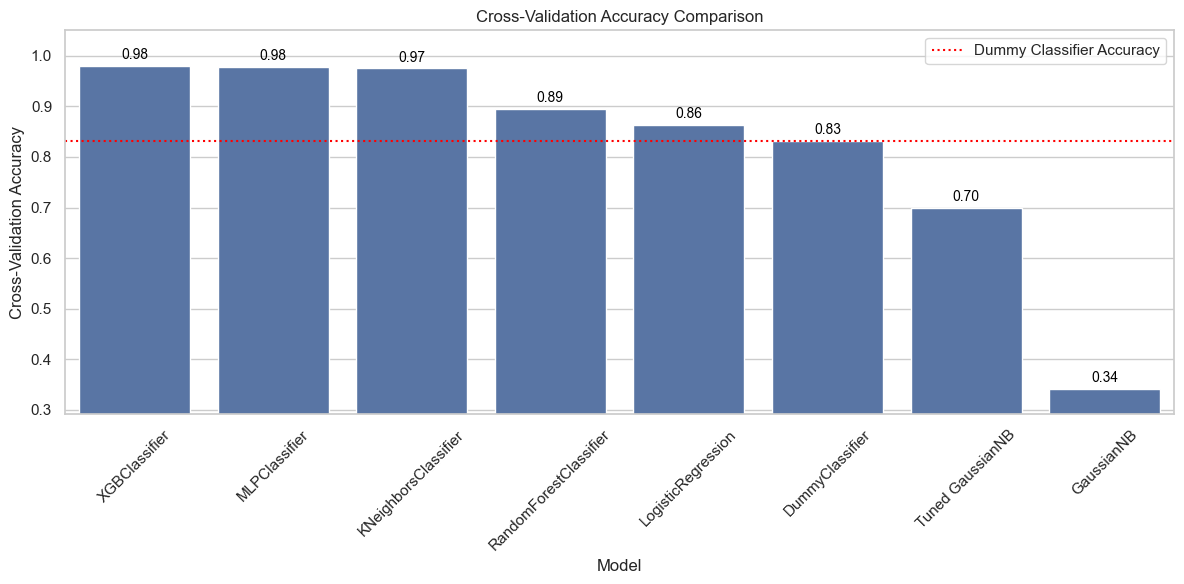

In [328]:
def plot_accuracy_comparison(results_df, dummy_classifier_accuracy):
    # Sort the DataFrame by 'Cross-Validation Accuracy' in descending order
    sorted_results_df = results_df.sort_values(by='Cross-Validation Accuracy', ascending=False)
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='Cross-Validation Accuracy', data=sorted_results_df)
    
    # Add text labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.axhline(y=dummy_classifier_accuracy, color='red', linestyle='dotted', label='Dummy Classifier Accuracy')
    plt.title('Cross-Validation Accuracy Comparison') 
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation Accuracy')
    plt.ylim(min(results_df['Cross-Validation Accuracy'] - 0.05), 1.05)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_accuracy_comparison(results_df, results_df.loc[0]['Cross-Validation Accuracy'])